# Imports

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# How has Russian equipment  and Personnel losses changed over time?

In [37]:
russian_equip = pd.read_csv('russia_losses_equipment.csv')
russian_pers = pd.read_csv('russia_losses_personnel.csv')
russian_equip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       655 non-null    object 
 1   day                        655 non-null    int64  
 2   aircraft                   655 non-null    int64  
 3   helicopter                 655 non-null    int64  
 4   tank                       655 non-null    int64  
 5   APC                        655 non-null    int64  
 6   field artillery            655 non-null    int64  
 7   MRL                        655 non-null    int64  
 8   military auto              65 non-null     float64
 9   fuel tank                  65 non-null     float64
 10  drone                      655 non-null    int64  
 11  naval ship                 655 non-null    int64  
 12  anti-aircraft warfare      655 non-null    int64  
 13  special equipment          636 non-null    float64

In [44]:
equip_df = russian_equip.fillna(0)
equip_df.drop(columns=['greatest losses direction', 'day'],inplace = True)

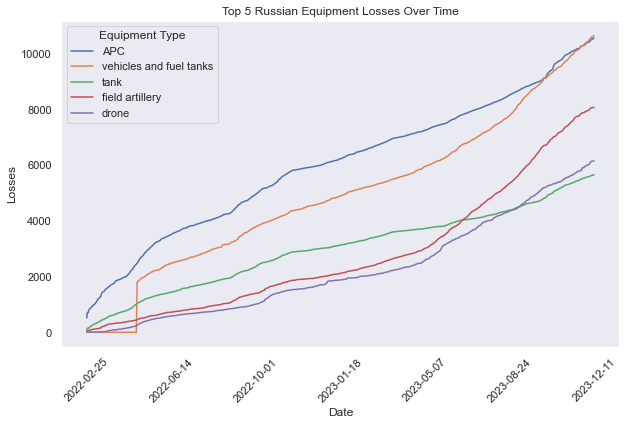

In [65]:
# Calculate the sum of values for each column
sum_values = equip_df.iloc[:, 1:].sum(axis=0)

# Select the top 5 columns with the highest sum values
top_columns = sum_values.nlargest(5).index.tolist()

# Subset the DataFrame to include only the top 5 columns
df_top5 = equip_df[['date'] + top_columns]

# Melt the DataFrame to long format for Seaborn
df_long = pd.melt(df_top5, id_vars=['date'], var_name='Variable', value_name='Value')

# Create a time series plot using Seaborn
sns.set_style("dark")
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='Value', hue='Variable', data=df_long)

# Optionally, you can add labels and a legend
plt.title('Top 5 Russian Equipment Losses Over Time')
plt.xlabel('Date')
plt.ylabel('Losses')
plt.legend(title='Equipment Type')

xtick_positions = [df_top5['date'].iloc[i] for i in range(0, len(df_top5['date']), len(df_top5['date']) // 6)]
plt.xticks(xtick_positions, rotation=45)  # Adjust rotation as needed

plt.show()

# Introduction

The above plot shows the losses of the top five most used equipment by the Russian army. Across all these equipments, Russia has been reporting increases in losses consitently since Feburary of 2022. The most used piece of equipment are APC's (Amphibous Personel Carriers) which are basically armored vehicles with a turret mainly used to transport troops in high danger areas.

# Trends

Analyzing trends of different equipments, we can see that since the beginning of 2022, APC's and Tanks are following a logorithmic growth, meaning they are growing but the rate of growth is not necessarily increasing. These types of trends usually lead to some kind of plateau. In contrast, Vehicles and fuel tanks, field artillery and drones all are seeing exponential growths. Meaning that the rate of losses for these equipments is increasing.

# So what?

After analyzing this figure, we have multiple possible avenues of insight. Firstly, We can make the assumption that since the beginning of the war, Russia has increased their deployment of equipment into this war. After all, no equipment could see an increase in losses without a larger supply of equipment to lose. The second and more strategic insight, is that the Ukrainian Army has been progressivley getting better at destroying russian equipment. Just because the supply of equipment increases, doesn't necessarily mean that their has to be an increase in losses. For example, the Russian army could have potentially overwhelmed the Ukrainina army and forced surrender in battles, but based on the data, we can assume that this was not the case. All in all, this figure reports positive insight for the Ukrainians and negative for the Russians.

In [73]:
russian_pers.drop(columns='personnel*', inplace=True)

KeyError: "['personnel*'] not found in axis"

In [96]:
russian_pers = russian_pers.fillna(0)
russian_pers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       655 non-null    object 
 1   day        655 non-null    int64  
 2   personnel  655 non-null    int64  
 3   POW        655 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 20.6+ KB


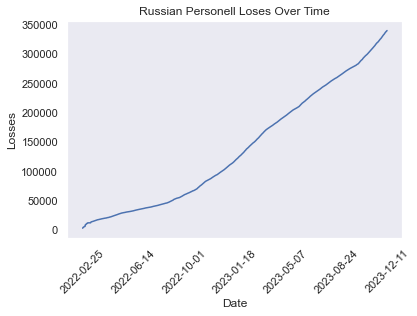

In [78]:
sns.lineplot(data=russian_pers, x='date', y='personnel')

xtick_positions = [russian_pers['date'].iloc[i] for i in range(0, len(russian_pers['date']), len(russian_pers['date']) // 6)]
plt.xticks(xtick_positions, rotation=45)  # Adjust rotation as needed

plt.title('Russian Personell Loses Over Time')
plt.xlabel('Date')
plt.ylabel('Losses')

plt.show();

# Intro

This figure shows the losses of Russian personell over time. The increase of personell lost appears to be following a slight exponential trend since Feburary 2022. This is very upsetting to see. After this graph printed in my notebook I was frozen for a few minutes. These numbers are so sad to see, all the families and friends that are losing someone in this war. Rest in Peace to all of those involved in this war of nonsense.

# Statistics

In [97]:
print('Russian Personnel loss totals are:',russian_pers.tail(1)['personnel'].values[0])
print('Russian Prisoner of War totals are:',russian_pers['POW'].max())

Russian Personnel loss totals are: 339850
Russian Prisoner of War totals are: 496.0
